# Fuse Lasso Simulation

For $n_1$ from the set of nodes $\{n_i\}_{i=0}^{d}$, I generate coefficients $\{\beta_1(t)\}_{i=1}^{d}$ that are relatively smooth over $\{t_i\}_{i=1}^{T}$. I then calculate $y_t = \sum_{i=1}^{d}x_{i,t}\beta_1(t) + \epsilon$.

With this data, I estimate the betas subject to fused-lasso regression and end up getting very good results.

The code right now is set to only estimate $n_1$, in my other version of the code I am able to estimate all the nodes. I am making progress with stitching them together. 

In [1]:
import numpy as np
import cvxpy as cp
from numpy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
plt.rcParams.update({'font.size': 15})

class fuse_lasso:
    
    DELTA = 0.01
    def __init__(self, M):
        self.M = M
        self.nodes = list(M.columns)
        self.T = M.shape[0]
        self.d = M.shape[1]
        self.diff_matr = self.make_diff_matr()
        self.lambd_grid = np.linspace(0, 2, 5)
        self.alpha_grid = np.linspace(0, 2, 5)
        
    def make_diff_matr(self):
        D = (np.identity(self.T) + np.diag([-1]*(self.T-1),k=1))[:-1]
        return D
    
    def MSE(self, X, y, beta):
        return (.5)*sum([(y[t] - sum([beta[t][i]*X[t][i] for i in range(self.d-1)]))**2 for t in range(self.T)])

    def l1_norm(self, beta):
        return sum([cp.norm1(beta[t]) for t in range(self.T)])

    def fusion(self, beta):
        return sum([cp.norm1(vec) for vec in [self.diff_matr@beta.T[i] for i in range(self.d-1)]])

    def obj_func(self, X, y, beta_matr, _lamda_, _alpha_):
        return self.MSE(X, y, beta_matr) + _lamda_*self.l1_norm(beta_matr) + _alpha_*self.fusion(beta_matr)
    
    def func(self):
        error_df = []
        for node_i in self.nodes[:1]: # only check node1
            y = self.M[node_i].to_numpy()
            X = self.M[[j for j in self.nodes if j != node_i]].to_numpy()

            # node_i optimization 
            _lambd_ = cp.Parameter(nonneg=True)
            _alpha_ = cp.Parameter(nonneg=True)
            beta_matr = cp.Variable(shape = (self.T, self.d-1))
            optim_problem = cp.Problem(
                cp.Minimize(self.obj_func(X, y, beta_matr, _lambd_, _alpha_))
            )
            
            for l in self.lambd_grid:
                _lambd_.value = l
                for a in self.alpha_grid:
                    _alpha_.value = a
                    optim_problem.solve(solver='ECOS')
                    error_df.append({'node': node_i,
                                     'l': l, 'a': a,  
                                     'error': optim_problem.value, 
                                     'beta_matrix': beta_matr.value})
        return pd.DataFrame(error_df)

In [2]:
T = 200
d = 2

delta = 0.05
beta = [np.array([np.random.uniform(-0.01, .2) for i in range(d)])]
for i in range(T-1):
    b_t = beta[-1]
    sparsify = [np.random.choice([0, i], p = [.1, .9]) for i in b_t]
    b_t = [np.random.choice([np.random.uniform(-0.01, .2), 0], p = [0.1, .9]) if abs(i) < delta else i for i in sparsify]
    beta.append(b_t + np.random.normal(0, .01, d))
beta = np.array(beta)

In [3]:
X = np.array([np.random.uniform(0, .01, d) for i in range(T)]).T

for i in range(len(X)):
    X[i]+= np.random.exponential(2, T)
X = X.T
y = []
for i in range(len(beta)):
    y.append(X[i] @ beta[i])

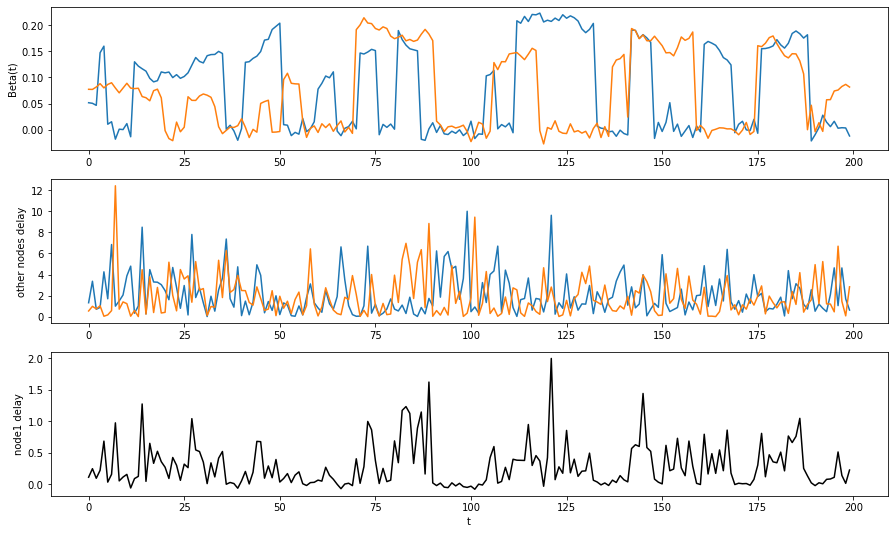

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,9))

ax1.set_ylabel('Beta(t)')
ax1.plot([i for i in range(T)], beta)

ax2.set_ylabel('other nodes delay')
ax2.plot([i for i in range(T)], X)

ax3.set_xlabel('t')
ax3.set_ylabel('node1 delay')
ax3.plot([i for i in range(T)], y, color = 'k')
plt.show()

In [5]:
# fused
new_X = [list(i) for i in X.T]
new_X.insert(0, y)
M = np.array(new_X)
M = pd.DataFrame(M).T

fuse_data = fuse_lasso(M).func().sort_values(by = ['error'])

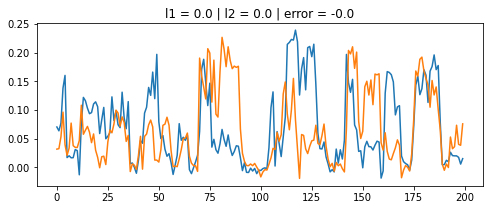

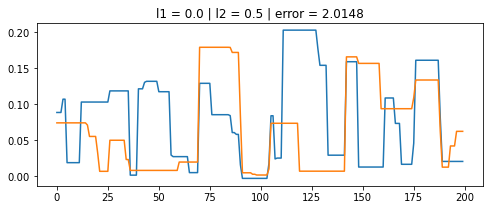

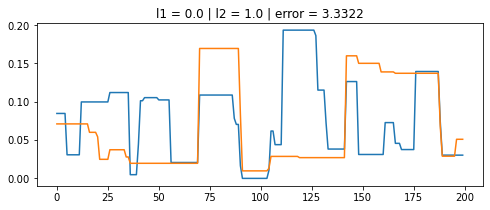

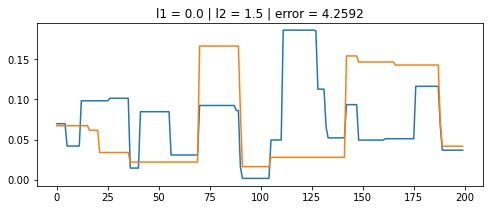

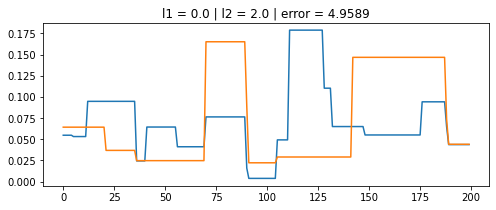

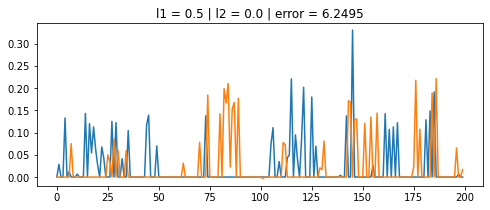

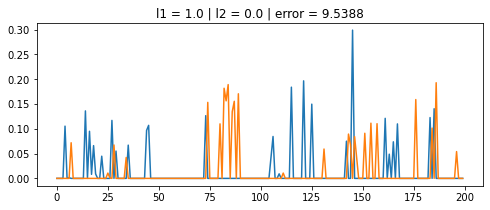

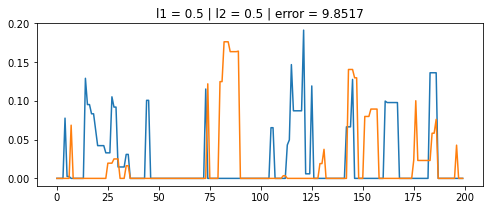

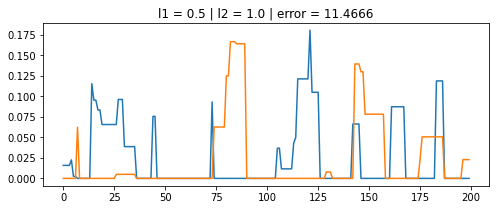

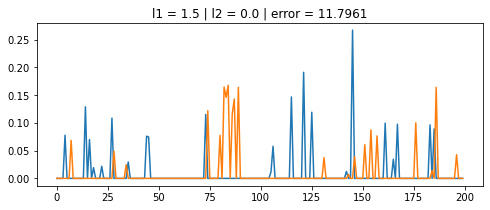

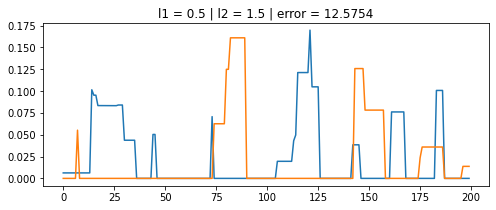

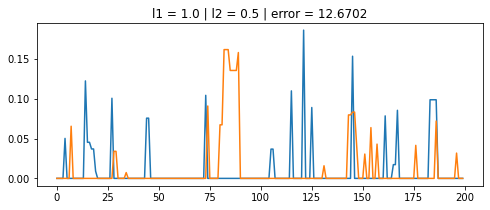

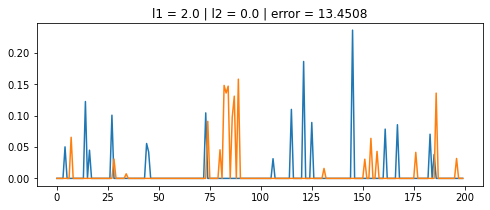

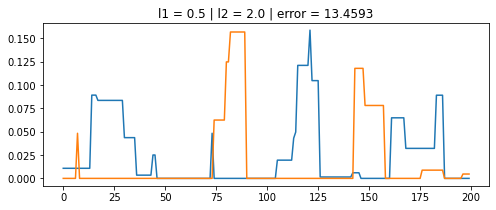

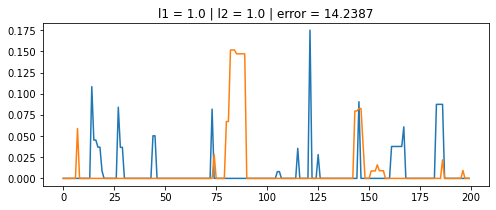

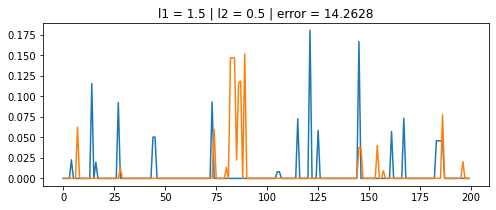

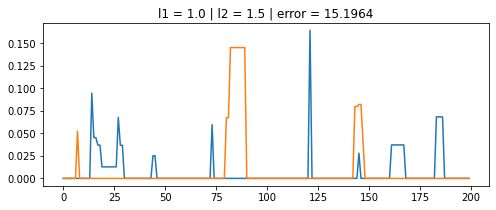

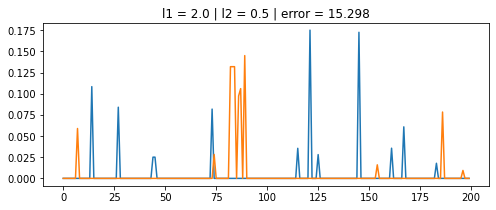

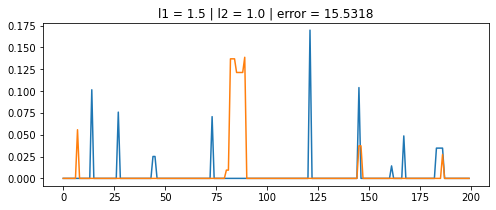

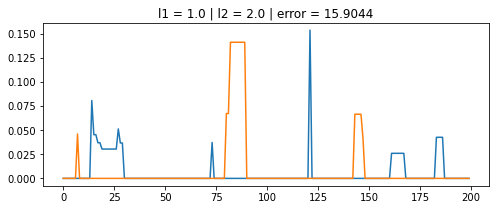

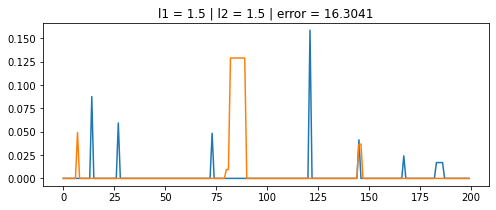

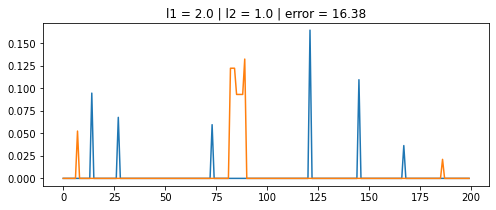

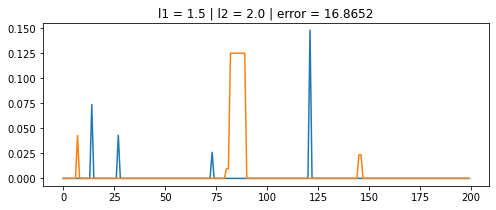

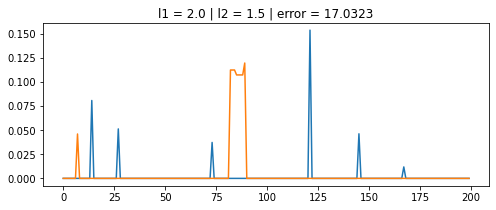

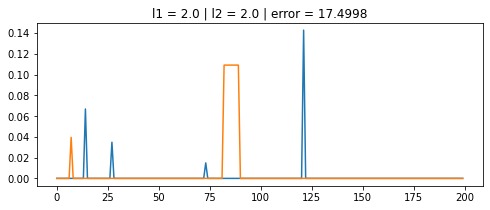

In [6]:
for i in range(len(fuse_data)):
    plt.figure(figsize = (8,3))
    row = fuse_data.iloc[i]
    beta_mat = row['beta_matrix'].T
    for i in beta_mat:
        plt.plot([i for i in range(T)], i)
        plt.title('l1 = {} | l2 = {} | error = {}'.format(
            round(row['l'], 4), 
            round(row['a'],4),
            round(row['error'],4)))
    plt.show()

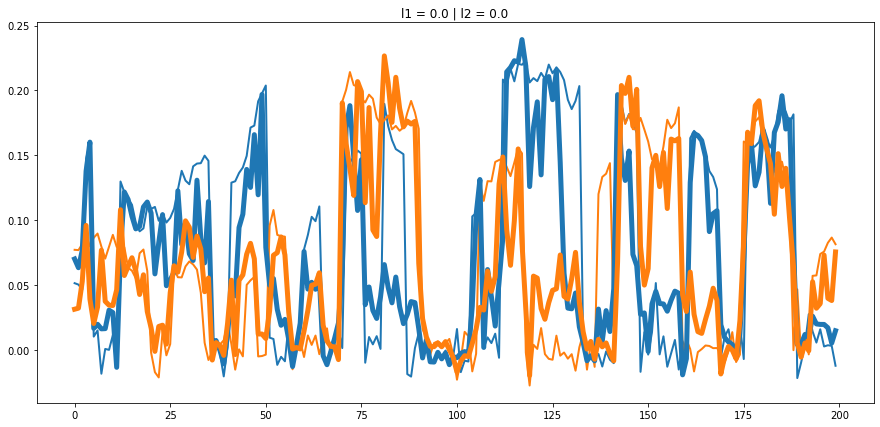

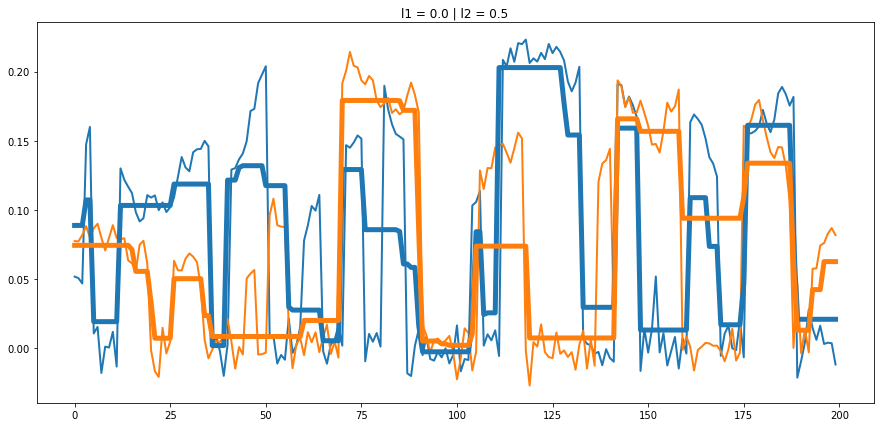

In [7]:
clrs1 = ['tab:blue', 'tab:orange']
clrs2 = ['tab:blue', 'tab:orange']

best = fuse_data.iloc[0]
plt.figure(figsize = (15,7))
plt.title('l1 = {} | l2 = {}'.format(best['l'], best['a']))

for i in range(len(beta.T)):
    plt.plot([i for i in range(T)], beta.T[i], color =clrs1[i], linewidth = 2)

beta_mat = best['beta_matrix'].T
for i in range(len(beta_mat)):
    plt.plot([i for i in range(T)], beta_mat[i], color =clrs2[i], linewidth = 5)
    
plt.show()

clrs1 = ['tab:blue', 'tab:orange']
clrs2 = ['tab:blue', 'tab:orange']

best = fuse_data.iloc[1]
plt.figure(figsize = (15,7))
plt.title('l1 = {} | l2 = {}'.format(best['l'], best['a']))

for i in range(len(beta.T)):
    plt.plot([i for i in range(T)], beta.T[i], color =clrs1[i], linewidth = 2)

beta_mat = best['beta_matrix'].T
for i in range(len(beta_mat)):
    plt.plot([i for i in range(T)], beta_mat[i], color =clrs2[i], linewidth = 5)
    
plt.show()